In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from pprint import pprint
import os
sns.set_style('white')
sns.set_context('poster')
sns.set_palette(['#E97F02', '#490A3D', '#BD1550']) #http://www.colourlovers.com/palette/848743/(%E2%97%95_%E2%80%9D_%E2%97%95)
%matplotlib inline

In [2]:
direc = '../../Data/2_eye/Clean/Game/'

In [3]:
files = [f for f in os.listdir(direc) if ((f[0] != "_") & (f[0] != "."))]
subjects = [f[:2] for f in files]
dataset = [pd.read_csv(direc + f).drop('Unnamed: 0', axis=1)  for f in files] #
datadict = dict(zip(subjects, dataset))

In [4]:
oberr = pd.read_csv('../1_gen/objective_errors.csv')
def bits2boards(num):
    s = '{0:b}'.format(num)
    return '0'*(36-len(s)) + s

oberr.loc[:, 'bp'] = oberr.loc[:, '0_pieces'].map(bits2boards)
oberr.loc[:, 'wp'] = oberr.loc[:, '1_pieces'].map(bits2boards)

oberr = oberr.loc[:, ['bp', 'wp', 'color', 'Game_theoretic_value', 
                      'Confirmed', 'value_Zeyan ', 'confirmed_Zeyan']]
oberr.columns = ['bp', 'wp', 'color', 'gtv', 'gtv_c', 'zv', 'zv_c']

positions = pd.read_csv('../1_gen/experiment_boards_new.txt', sep='\t', 
            names=['bp', 'wp', 'a', 'aval', 'b', 'bval', 'c', 'mu'])
positions.loc[:, 'attempts'] = 0
positions.loc[:, 'errors'] = 0

In [5]:
gamout = ['subject', 'color', 'bp', 'wp', 'response', 'rt']
afcout = ['subject', 'color', 'bp', 'wp', 'response', 'rt', 'a', 'b', 'aval', 'bval']
evaout = ['subject', 'color', 'bp', 'wp', 'response', 'rt', 'val']
new_cols = ['a', 'b', 'aval', 'bval', 'val']

In [6]:
def append_tables(df):
    for i in new_cols:
        df.loc[:, i] = np.nan
    d = df.loc[df.status=="AFC2", :]
    
    for obs in d.index.values:
        c = positions.loc[
            (positions.bp == d.loc[obs, 'bp']) & (positions.wp == d.loc[obs, 'wp']), 
            :]
        if len(c) > 1:
            c = int(c.loc[c.index.values[0], :])
        if len(c) == 1:
            for h in ['a', 'b', 'aval', 'bval']:
                df.loc[obs, h] = int(c.loc[:, h].values[0])
    
    d = df.loc[df.status=='EVAL', :]
    for obs in d.index.values:
        o = oberr.loc[
            (oberr.bp == d.loc[obs, 'bp']) & (oberr.wp == d.loc[obs, 'wp']), 
            :]
        if len(c) > 1:
            o = o.loc[o.index.values[0], :]
        if len(c) == 1:
            df.loc[obs, 'val'] = o.loc[:, 'gtv'].values[0]
    
    return df

def find_errors(df):
    for i in ['error', 'val']:
        df.loc[:, i] = np.nan
    d = df.loc[df.status=="AFC2", :]
    
    for obs in d.index.values:
        
        c = positions.loc[
            (positions.bp == d.loc[obs, 'bp']) & (positions.wp == d.loc[obs, 'wp']), 
            :]
        o = oberr.loc[
            (oberr.bp == d.loc[obs, 'bp']) & (oberr.wp == d.loc[obs, 'wp']), 
            :]
        
        if len(c) > 1:
            c = c.loc[c.index.values[0], :]
        if len(o) > 1:
            o = o.loc[o.index.values[0], :]
        if len(c) == 1:
            positions.loc[c.index.values[0], 'attempts'] += 1
            if d.loc[obs, 'response'] == c.loc[:, 'a'].values[0]:
                if c.loc[:, 'aval'].values[0] < c.loc[:, 'bval'].values[0]:
                    df.loc[obs, 'error'] = 1
                    positions.loc[c.index.values[0], 'errors'] += 1
                else:
                    df.loc[obs, 'error'] = 0
            elif d.loc[obs, 'response'] == c.loc[:, 'b'].values[0]:
                if c.loc[:, 'aval'].values[0] > c.loc[:, 'bval'].values[0]:
                    df.loc[obs, 'error'] = 1
                    positions.loc[c.index.values[0], 'errors'] += 1
                else:
                    df.loc[obs, 'error'] = 0
        if len(o) == 1:
            df.loc[obs, 'val'] = o.loc[:, 'gtv'].values[0]
    return df

dataset = list(map(append_tables, dataset))

In [7]:
def export_data(ds, save=False):
    gam = pd.concat([d.loc[~d.status.isin(['AFC2', 'EVAL']) & (d.rt != 0), gamout]
                    for d in dataset]).reset_index(drop=True)
    afc = pd.concat([d.loc[d.status == 'AFC2', afcout] 
                    for d in dataset]).reset_index(drop=True)
    afc.loc[:, new_cols[:-1]] = afc.loc[:, new_cols[:-1]].astype(int)
    eva = pd.concat([d.loc[d.status == 'EVAL', evaout]
                    for d in dataset]).reset_index(drop=True)
    eva.loc[:, 'val'] = eva.loc[:, 'val'].astype(int)
    if save:
        gam.to_csv(direc + '/_summaries/all_games.csv', header=False, index=False)
        afc.to_csv(direc + '/_summaries/all_afcs.csv', header=False, index=False)
        eva.to_csv(direc + '/_summaries/all_evals.csv', header=False, index=False)
    
    return gam, afc, eva

g, a, e = export_data(dataset, save=True);
g.head()

,subject,color,bp,wp,response,rt
0,0,0,000000000000000000000000000000000000,100000000000000000000000000000000000,0,9.193
1,0,0,000000000000000000000000000000000000,010000000000000000000000000000000000,1,1.009
2,0,0,000000000000000000000000000000000000,001000000000000000000000000000000000,2,0.878
3,0,0,000000000000000000000000000000000000,000100000000000000000000000000000000,3,1.160
4,0,0,000000000000000000000000000000000000,000010000000000000000000000000000000,4,0.919


# Difficulties

In [7]:
gxc, wxc, dxc = [pd.read_csv('../Statistics/' + c + '.csv').drop('Unnamed: 0', axis=1) 
    for c in ['games_x_computer', 'wins_x_computer', 'draws_x_computer']]

[ 0.11111111  0.15        0.21428571  0.3125      0.52        0.52631579
  0.375       0.4         0.6         0.23076923  0.45454545  0.32432432
  0.5         0.33333333  0.42857143  0.60606061  0.66666667  0.65625
  0.52941176  0.52173913  0.7         0.46153846  0.66666667  0.8
  0.66666667  0.375       0.375       0.66666667  0.33333333  0.8       ]


/Users/gianni/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


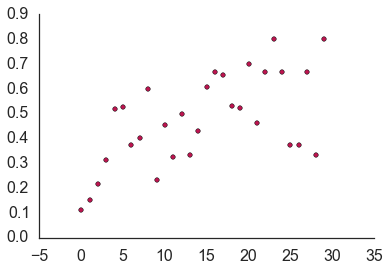

In [8]:
difficulties = np.nansum(wxc.values, axis=0) / np.nansum(gxc.values, axis=0)
print(difficulties)
plt.scatter(np.arange(difficulties.size), difficulties, c='#BD1550')
sns.despine()

In [9]:
x = np.arange(difficulties.size)
y = difficulties + (np.nansum(dxc.values, axis=0) / np.nansum(gxc.values, axis=0))

/Users/gianni/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


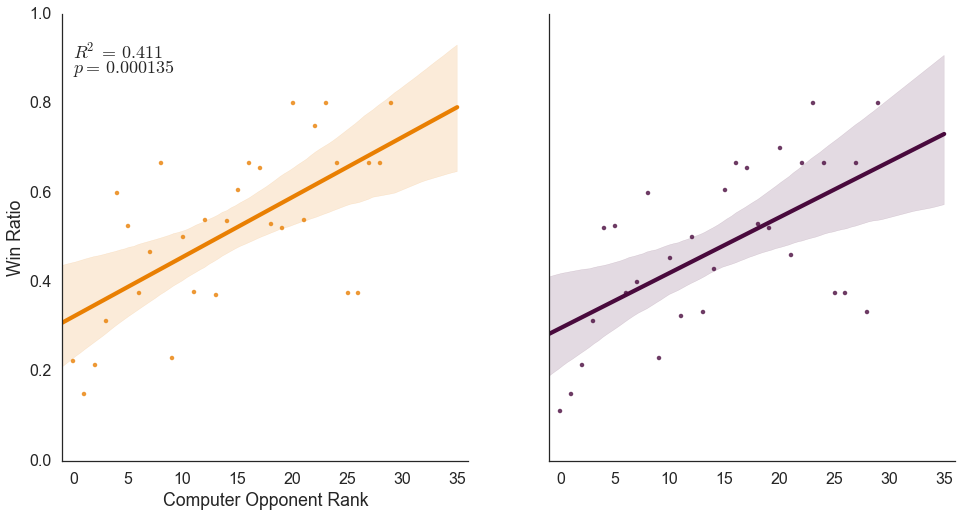

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16,8), squeeze=False, sharex=True, sharey=True)
slope, intercept, rval, pval, stderr = sts.mstats.linregress(x, y)
# print("R^2 = " + str(rval**2))
# print("p = " + str(pval))
sns.regplot(x, y, ax=axes[0, 0])
sns.regplot(x, difficulties, ax=axes[0, 1])
axes[0, 0].text(0, .9, 
                s=("$R^2 = \ {rval:.3f}$").format(rval=(rval**2)),
                fontsize=18)
axes[0, 0].text(0, .87,
                s=("$p = \ {pval:.3}$").format(pval=pval),
                fontsize=18)
axes[0, 0].set_xlim([-1, 36])
axes[0, 0].set_ylabel('Win Ratio')
axes[0, 0].set_xlabel('Computer Opponent Rank')
sns.despine()
fig.savefig('../Figures/Winrate_computerrank.png')